### Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None)
import os
import zipfile
from tqdm.notebook import tqdm

import skimage.transform
import cv2

import torch
import torchvision
from torch.utils import data
from torch.autograd import Variable

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense, Flatten
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

/Users/taneja/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/taneja/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/taneja/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/taneja/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [5]:
# Image settings 
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
IMAGES_PATH = './images/image_train/' # why was it image_test before ?

In [7]:
def get_images_train_data(img_paths, output_shape=(None, None)):
    try:
        return(np.load(IMAGES_PATH + 'training_images.npy'))
    except:
        X_data = np.array([skimage.transform.resize(plt.imread((IMAGES_PATH + path + '.jpg'))[:,:,:3], 
                                                        output_shape=output_shape, mode='constant', 
                                                      preserve_range=True) for path in img_paths], 
                            dtype=np.uint8)

          # let's save the numpy images array for faster loading
        np.save(IMAGES_PATH + 'training_images.npy', X_data)
        return X_data

In [8]:
# loading training and test csv
X_train = pd.read_csv('X_train.csv', header=0, names=['id','designation','description','productid','imageid'])
y_train = pd.read_csv('Y_train.csv', header=0, names=['id','prdtypecode'])

In [9]:
# build filenames in the string format : product_123_image_456 from X_train
X_train['imagefilename'] = X_train.apply(lambda x: 'image_'+str(x['imageid'])+'_product_'+str(x['productid']), axis=1)
X_train.head()

,id,designation,description,productid,imageid,imagefilename
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,image_1263597046_product_3804725264
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,image_1008141237_product_436067568
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,image_938777978_product_201115110
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,image_457047496_product_50418756
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,image_1077757786_product_278535884


In [11]:
# subsampling data

def subSample(df, maxCount):
    prd_dict = dict()
    
    for i in df.prdtypecode.value_counts().index:
        prd_dict[i]=0
    
    ranks = []
    for i in df.prdtypecode:
        prd_dict[i] = prd_dict[i] +1
        ranks.append(prd_dict[i])
    
    df['rank'] = ranks
    temp = df[df['rank']<=maxCount]
    temp.drop(columns=['rank'],inplace=True)
    return temp

def mapPrdIdtoInteger(df, col_name): # function to map prdTypeCode to Integer 
    uniqueProdIds = [i for i in pd.unique(df[col_name].values)]
    prdIdDict = {}
    for i in range(len(uniqueProdIds)):
        prdIdDict.setdefault(uniqueProdIds[i],i)
    return prdIdDict

In [12]:
y_train_subsampled = subSample(y_train.copy(), 500)
subsampled_ids = y_train_subsampled['id']

temp_df = pd.DataFrame(y_train_subsampled['prdtypecode'])

map_dict = mapPrdIdtoInteger(temp_df,'prdtypecode') # encoding map 
inverse_map_dict = dict((v,k) for k,v in map_dict.items()) # decoding map for getting back actual ProductId

y_train_subsampled = pd.DataFrame.replace(temp_df, to_replace = map_dict)

X_train_subsampled = X_train.loc[subsampled_ids]

/Users/taneja/Anaconda3/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
# now let's read all the image filenames
image_filenames = [f for f in X_train_subsampled['imagefilename']]

### Loading all training images

In [15]:
sample_length = len(X_train_subsampled)

train_images_np=np.zeros((sample_length,IMG_HEIGHT,IMG_WIDTH,3))

for i,fi in tqdm(enumerate(image_filenames)):
    pic = cv2.imread(IMAGES_PATH + fi + '.jpg')
    pic = cv2.resize(pic,(IMG_HEIGHT,IMG_WIDTH))
    train_images_np[i] = pic

### Axes swapping from h,w,c -> c,h,w

In [16]:
# Uncomment below if using Pytorch
train_images_np = np.moveaxis(train_images_np, -1, 1)
train_images_np.shape

(13500, 3, 128, 128)

### Train Test Split of Data

In [17]:
n = int(round(0.8*len(X_train_subsampled),0))

y_train_subsampled = y_train_subsampled.prdtypecode.values

x_train_cv = train_images_np[:n]
x_val = train_images_np[n:]
y_train_cv = y_train_subsampled[:n]
y_val = y_train_subsampled[n:]

### Using PyTorch

In [18]:
batch_size = 32

# this cell takes a lot of time and increases with input size

# transforming the numpy array to a torch tensor
tensor_X_train = torch.Tensor(x_train_cv)
tensor_Y_train = torch.Tensor(y_train_cv).type(torch.LongTensor)

# transforming the torch tensors to a dataset
trainset = torch.utils.data.TensorDataset(tensor_X_train, tensor_Y_train)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=False)

tensor_X_val = torch.Tensor(x_val)
tensor_Y_val = torch.Tensor(y_val).type(torch.LongTensor)

valset = torch.utils.data.TensorDataset(tensor_X_val, tensor_Y_val)
val_dataloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# # *****START CODE
# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         #starting image size = 64X64
#         self.conv1 = nn.Conv2d(3, 16, 3, padding=(1,1)) # in_channels, out_channels, kernel_size
#         self.conv2 = nn.Conv2d(16,16,3, padding=(1,1))
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.dropout1 = nn.Dropout2d(0.1)
#         self.conv3 = nn.Conv2d(16, 32, 3, padding=(1,1))
#         self.conv4 = nn.Conv2d(32, 32, 3, padding=(1,1))
#         self.pool2 = nn.MaxPool2d(2, 2)
#         self.dropout2 = nn.Dropout2d(0.1)

# #FLATTENING
#         self.fc1 = nn.Linear(32 * 64 * 64, 512)
#         self.dropout3 = nn.Dropout(p=0.3)
#         self.fc2 = nn.Linear(512, 256)
#         self.fc3 = nn.Linear(256, 27)


#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.dropout1(self.pool1(F.relu(self.conv2(x))))
#         x = self.conv3(x)
#         x = self.dropout2(self.pool2(F.relu(self.conv4(x))))
#         x = x.view(-1, 32 * 64 * 64)
#         x = F.relu(self.dropout3(self.fc1(x)))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# class ConvNet(nn.Module): # Best so far
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 96, kernel_size=3,stride=1,padding=1)   # 3X64X64 to 96X64X64       
#         self.conv2 = nn.Conv2d(96, 96, kernel_size=3,stride=1,padding=1)  # 96X64X64 to 96X64X64                 
#         self.conv3 = nn.Conv2d(96, 96, kernel_size=3,stride=2,padding=1)  # 96X64X64 to 96X32X32                 
#         self.conv4 = nn.Conv2d(96, 192, kernel_size=3,stride=1,padding=1)  # 96X32X32 to 192X32X32                 
#         self.conv5 = nn.Conv2d(192, 192, kernel_size=3,stride=1,padding=1)   
#         self.conv6 = nn.Conv2d(192, 192, kernel_size=3,stride=2,padding=1)  # 192X32X32 to 192X16X16                 
#         self.conv7 = nn.Conv2d(192, 192, kernel_size=3,stride=1,padding=0)  # 192X16X16 to 192X14X14
#         self.conv8 = nn.Conv2d(192, 10, kernel_size=1,stride=1,padding=0)   # 192X14X14 to 10X14X14    
#         self.conv9 = nn.Conv2d(10, 10, kernel_size=1,stride=1,padding=0)    # 10X14X14 to 10X14X14 
#         self.dropout = nn.Dropout(p=.5)
#         # self.pool = nn.AvgPool2d(kernel_size=6, stride=1, padding=0) 
#         self.fc1 = nn.Linear(10*14*14,27)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = self.dropout(F.relu(self.conv3(x)))
#         x = F.relu(self.conv4(x))
#         x = F.relu(self.conv5(x))
#         x = self.dropout(F.relu(self.conv6(x)))
#         x = F.relu(self.conv7(x))
#         x = F.relu(self.conv8(x))
#         x = F.relu(self.conv9(x))
#         x = x.view(-1, 10*14*14)
#         x = self.fc1(x)
#         return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        #starting image size = 128x128
        self.conv1 = nn.Conv2d(3, 16, 3, padding=(1,1)) # in_channels, out_channels, kernel_size
        self.conv2 = nn.Conv2d(16,40,3, padding=(1,1))
        self.conv3 = nn.Conv2d(40, 70, 3, padding=(1,1))
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.4)

        self.fc1 = nn.Linear(70 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 27)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(self.pool(F.relu(self.conv2(x))))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 70 * 16 * 16)
        x = F.relu(self.dropout2(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
import torch.optim as optim

model = ConvNet()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
epochs = 10

In [21]:
import time

train_loss_list = []
val_loss_list = []

#Print all of the hyperparameters of the training iteration:
print("===== HYPERPARAMETERS =====")
print("batch_size=", batch_size)
print("epochs=", epochs)
print("learning_rate=", learning_rate)
print("=" * 30)

n_batches = len(train_dataloader)
training_start_time = time.time()

for epoch in range(epochs):


    running_loss = 0.0
    print_every = 20 # 10
    start_time = time.time()
    total_train_loss = 0

    for i, data in enumerate(train_dataloader, 0):

        #Get inputs
        inputs, labels = data

        #Wrap them in a Variable object
        inputs, labels = Variable(inputs), Variable(labels)

        #Set the parameter gradients to zero
        optimizer.zero_grad()

        #Forward pass, backward pass, optimize
        outputs = model(inputs)
        loss_size = criterion(outputs, labels)
        loss_size.backward()
        optimizer.step()
        
        running_loss += loss_size.data
        total_train_loss += loss_size.data

        #Print every 10th batch of an epoch
        if (i + 1) % (print_every + 1) == 0:
            print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
            #Reset running loss and time
            running_loss = 0.0
            start_time = time.time()

    #At the end of the epoch, do a pass on the validation set
    total_val_loss = 0
    for inputs, labels in val_dataloader:

        #Wrap tensors in Variables
        inputs, labels = Variable(inputs), Variable(labels)

        #Forward pass
        val_outputs = model(inputs)
        val_loss_size = criterion(val_outputs, labels)
        total_val_loss += val_loss_size.data

    train_loss_list.append(total_train_loss)
    val_loss_list.append(total_val_loss)

    print("Validation loss = {:.2f}".format(total_val_loss / len(val_dataloader)))


    torch.save(model, 'model-elta-epoch-3.pkl')

print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

===== HYPERPARAMETERS =====
batch_size= 32
epochs= 10
learning_rate= 0.001
Epoch 1, 6% 	 train_loss: 8.28 took: 10.30s
Epoch 1, 12% 	 train_loss: 3.31 took: 9.89s
Epoch 1, 18% 	 train_loss: 3.35 took: 9.91s
Epoch 1, 24% 	 train_loss: 3.30 took: 10.06s
Epoch 1, 31% 	 train_loss: 3.31 took: 10.29s
Epoch 1, 37% 	 train_loss: 3.28 took: 10.05s
Epoch 1, 43% 	 train_loss: 3.32 took: 10.03s
Epoch 1, 49% 	 train_loss: 3.29 took: 10.14s
Epoch 1, 55% 	 train_loss: 3.27 took: 10.70s
Epoch 1, 62% 	 train_loss: 3.20 took: 10.03s
Epoch 1, 68% 	 train_loss: 3.18 took: 10.05s
Epoch 1, 74% 	 train_loss: 3.24 took: 10.17s
Epoch 1, 80% 	 train_loss: 3.13 took: 9.91s
Epoch 1, 86% 	 train_loss: 3.06 took: 9.94s
Epoch 1, 93% 	 train_loss: 2.86 took: 10.04s
Epoch 1, 99% 	 train_loss: 2.72 took: 10.32s
Validation loss = 2.93


/Users/taneja/Anaconda3/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 2, 6% 	 train_loss: 3.60 took: 11.14s
Epoch 2, 12% 	 train_loss: 3.36 took: 10.53s
Epoch 2, 18% 	 train_loss: 3.33 took: 10.56s
Epoch 2, 24% 	 train_loss: 3.32 took: 10.82s
Epoch 2, 31% 	 train_loss: 3.31 took: 10.36s
Epoch 2, 37% 	 train_loss: 3.28 took: 9.68s
Epoch 2, 43% 	 train_loss: 3.35 took: 9.63s
Epoch 2, 49% 	 train_loss: 3.31 took: 9.53s
Epoch 2, 55% 	 train_loss: 3.31 took: 9.57s
Epoch 2, 62% 	 train_loss: 3.22 took: 9.56s
Epoch 2, 68% 	 train_loss: 3.23 took: 9.65s
Epoch 2, 74% 	 train_loss: 3.21 took: 9.62s
Epoch 2, 80% 	 train_loss: 3.16 took: 9.61s
Epoch 2, 86% 	 train_loss: 2.92 took: 9.68s
Epoch 2, 93% 	 train_loss: 2.76 took: 9.61s
Epoch 2, 99% 	 train_loss: 2.56 took: 9.88s
Validation loss = 2.86
Epoch 3, 6% 	 train_loss: 3.68 took: 10.34s
Epoch 3, 12% 	 train_loss: 3.31 took: 11.03s
Epoch 3, 18% 	 train_loss: 3.28 took: 11.37s
Epoch 3, 24% 	 train_loss: 3.22 took: 11.45s
Epoch 3, 31% 	 train_loss: 3.13 took: 11.75s
Epoch 3, 37% 	 train_loss: 3.21 took: 11.74s


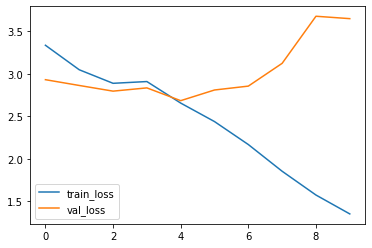

In [22]:
train_loss_list = [x/len(train_dataloader) for x in train_loss_list]
val_loss_list = [x/len(val_dataloader) for x in val_loss_list]

plt.plot(train_loss_list,label='train_loss')
plt.plot(val_loss_list,label='val_loss')
plt.legend()
plt.show()

In [23]:
# load the model
net = torch.load('model-elta-epoch-3.pkl')

#### Performance on Validation data

In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the validation set images: %d %%' % (100 * correct / total))

Accuracy of the network on the validation set images: 23 %


#### Performance on Train data

In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_dataloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train set images: %d %%' % (100 * correct / total))

Accuracy of the network on the train set images: 33 %


#### Prediction on Test data

In [26]:
TEST_IMAGES_PATH = './images/image_test/'

In [27]:
X_test = pd.read_csv('X_test.csv', header=0, names=['id','designation','description','productid','imageid'])
X_test['imagefilename'] = X_test.apply(lambda x: 'image_'+str(x['imageid'])+'_product_'+str(x['productid']), axis=1)
X_test.head()

,id,designation,description,productid,imageid,imagefilename
0,84916,Folkmanis Puppets - 2732 - Marionnette Et Théâ...,NaN,516376098,1019294171,image_1019294171_product_516376098
1,84917,Porte Flamme Gaxix - Flamebringer Gaxix - 136/...,NaN,133389013,1274228667,image_1274228667_product_133389013
2,84918,Pompe de filtration Speck Badu 95,NaN,4128438366,1295960357,image_1295960357_product_4128438366
3,84919,Robot de piscine électrique,<p>Ce robot de piscine d&#39;un design innovan...,3929899732,1265224052,image_1265224052_product_3929899732
4,84920,Hsm Destructeur Securio C16 Coupe Crois¿E: 4 X...,NaN,152993898,940543690,image_940543690_product_152993898


In [28]:
# X_test_subsampled = X_test[:100]
X_test_subsampled = X_test

image_filenames = [f for f in X_test_subsampled['imagefilename']]
sample_length = len(X_test_subsampled)

test_images=np.zeros((sample_length,IMG_HEIGHT,IMG_WIDTH,3))

for i,fi in tqdm(enumerate(image_filenames)):
    pic = cv2.imread(TEST_IMAGES_PATH + fi + '.jpg')
    pic = cv2.resize(pic,(IMG_HEIGHT,IMG_WIDTH))
    test_images[i] = pic

In [29]:
test_images = np.moveaxis(test_images, -1, 1)
test_images.shape

(13812, 3, 128, 128)

In [30]:
batch_size = 100

# transforming the numpy array to a torch tensor
tensor_X_test = torch.Tensor(test_images)

# transforming the torch tensors to a dataset
testset = torch.utils.data.TensorDataset(tensor_X_test)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=False)

In [31]:
predictions = np.array([])
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images = data[0]
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions = np.concatenate((predictions,predicted))


In [33]:
pd.DataFrame(predictions).to_csv('images23%.csv')